In [1]:
import os
import matplotlib.pyplot as plt

%matplotlib inline

Peaks at: [ 11338.10654  11356.2532   11419.99554 ... 268978.05747 270271.6253
 270704.19556]


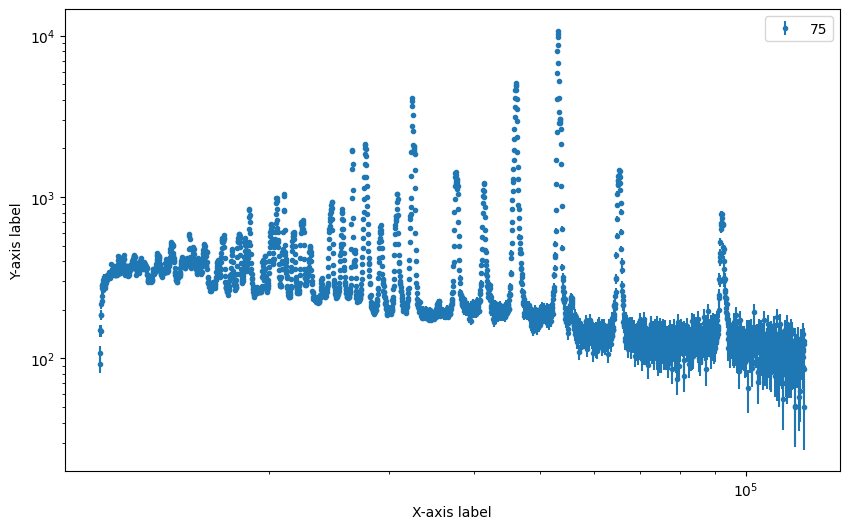

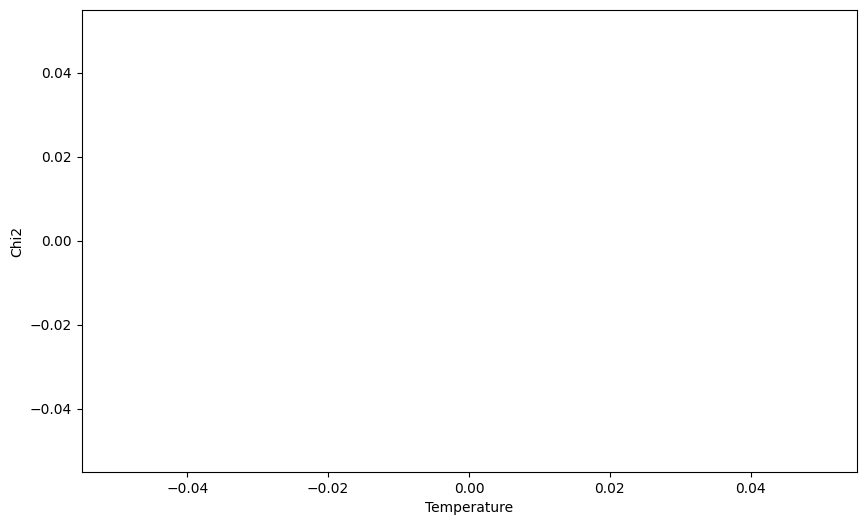

In [2]:
import numpy as np
from scipy.signal import find_peaks

# Assuming the files are text files and you want to read them into numpy arrays
file_list = os.listdir('/Users/mathieu/Dropbox/Work/experiments/illumine/PZT45ramp')
file_list.sort(key=lambda x: int(x.split('_')[3]))

plt.figure(figsize=(10, 6))
scale = 1
temp_list = []
chi2_list = []

for i, file in enumerate(file_list[:1]):
    if file.startswith('PZT_45'):
        temp = file.split('_')[3]
        tof, counts, err = np.loadtxt(os.path.join('/Users/mathieu/Dropbox/Work/experiments/illumine/PZT45ramp', file), comments="'").T
        # Identify peaks in the counts data
        peaks, _ = find_peaks(counts, height=0)
        print(f"Peaks at: {tof[peaks]}")
        if i == 0:
            tof0 = tof
            counts0 = counts
            err0 = err
        else:
            non_nan_indices = ~np.isnan(counts)
            non_nan_indices &= ~np.isnan(counts0)
            non_nan_indices &= ~np.isnan(err)
            non_nan_indices &= ~np.isnan(err0)
            non_nan_indices &= err > 0
            non_nan_indices &= err0 > 0
            chi2 = np.mean((counts[non_nan_indices]-counts0[non_nan_indices])**2 / err[non_nan_indices]**2)
            temp_list.append(temp)
            chi2_list.append(chi2)
            print(temp, chi2)
        nmax = len(tof) - 1000
        scale *= 10
        #plt.plot(tof[:nmax], counts[:nmax], label=file)
        plt.errorbar(tof[:nmax], scale*counts[:nmax], yerr=scale*err[:nmax], fmt='.', label=temp)

plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temp_list, chi2_list)
plt.xlabel('Temperature')
plt.ylabel('Chi2')
plt.show()


PZT_45_ramp_100_to_75_K.xye


/Users/mathieu/miniconda3/envs/sprig/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


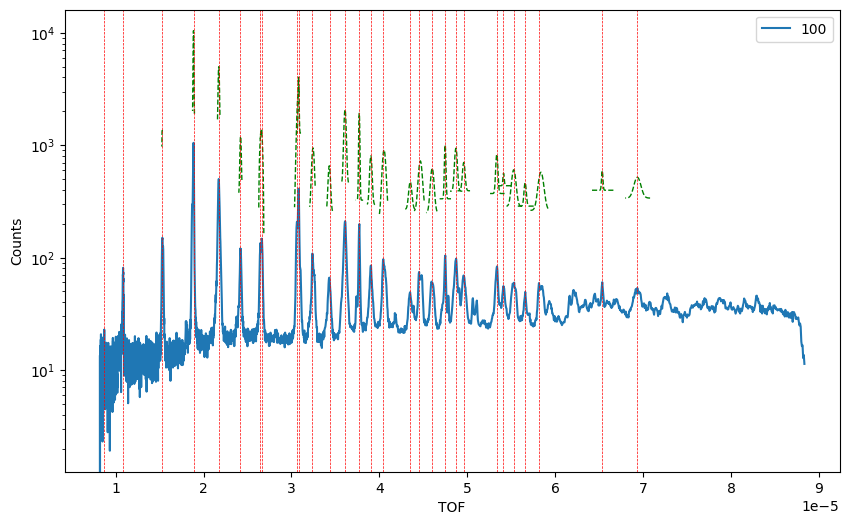

In [ ]:
# TODO: Fit peak in Q space to avoid weird widths
from scipy.optimize import curve_fit

index = 1
file = file_list[index]
print(file)
temp = file.split('_')[3]
tof, counts, err = np.loadtxt(os.path.join('/Users/mathieu/Dropbox/Work/experiments/illumine/PZT45ramp', file), comments="'").T
tof = tof[:nmax]
counts = counts[:nmax]
err = err[:nmax]

# Identify peaks in the counts data
peaks, _ = find_peaks(counts, prominence=20)

plt.figure(figsize=(10, 6))
plt.plot(1/tof, counts, label=temp)

# Define a Gaussian function
def gaussian(x, amp, cen, wid, bck):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2)) + bck


for peak in tof[peaks]:
    # Fit a Gaussian to each peak
    delta = 300
    mask = (tof > peak - delta) & (tof < peak + delta)
    try:
        popt, _ = curve_fit(gaussian, tof[mask], counts[mask], p0=[counts[mask].max(), peak, 10, 0])
    except:
        print(f"Failed to fit peak at {peak}")
        continue    
    plt.plot(1/tof[mask], 10*gaussian(tof[mask], *popt), color='green', linestyle='--', linewidth=1)
    plt.axvline(x=1/peak, color='r', linestyle='--', linewidth=0.5)

plt.xlabel('TOF')
plt.ylabel('Counts')
plt.xscale('linear')
plt.yscale('log')
plt.legend()
plt.show()